In [1]:
!pip install jovian
import jovian

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 1.0 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for uuid: filename=uuid-1.30-py3-none-any.whl size=6479 sha256=ec825c626a1c2c74f7158e41657d1147b321ddafbd62a7537e288704811c9b75
  Stored in directory: /home/kajetan/.cache/pip/wheels/e0/01/df/bd20df409bd81f8b99e6cd343c5f49731dc0a20eefefdafae0
Successfully built uuid


<IPython.core.display.Javascript object>

In [40]:
project_name = "Image-Generator"

In [3]:
!pip install opendatasets --quiet

In [5]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/splcher/animefacedataset'
od.download(dataset_url)

100%|██████████| 395M/395M [01:14<00:00, 5.57MB/s] 


In [6]:
import os

DATA_DIR = './animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [8]:
print(os.listdir(DATA_DIR + '/images')[:10])

['41695_2013.jpg', '40879_2013.jpg', '40565_2012.jpg', '33511_2011.jpg', '25700_2009.jpg', '22655_2008.jpg', '1266_2001.jpg', '35906_2011.jpg', '6348_2003.jpg', '8300_2004.jpg']


In [9]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [11]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)  # normalize the pixel values with mean & standard deviation of 0.5 for each channel

In [21]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=3,
                      pin_memory=True)

In [22]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

## Create a helper functions

In [23]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [33]:
permute?

Object `permute` not found.


In [28]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])  # Remove x and y ticks
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))  # permute(1, 2, 0) matplotlib requires color channels to be dimension: height, width channels

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

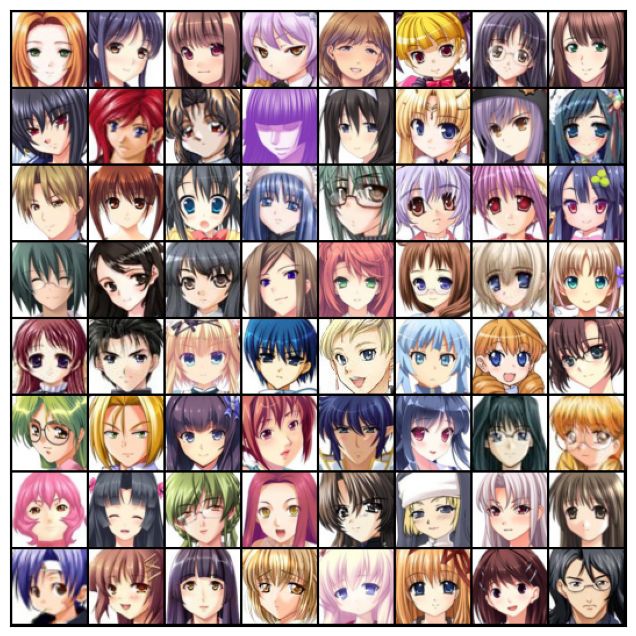

In [29]:
show_batch(train_dl)

## Using Gpu

In [42]:
def get_default_device():
    """Pick GPU id available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)   #  keyword is used to generate a generator object that yields batches of data after moving them to the specified device
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [46]:
device = get_default_device()
device

device(type='cuda')

In [48]:
train_dl = DeviceDataLoader(train_dl, device)  # `DeviceDataLoader` for automatically trainsferring batches of data to the GPU

In [49]:
import torch.nn as nn

In [51]:
discriminator = nn.Sequential(
    # in 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(negative_slope=0.2, inplace=True),
    # out: 64, 32, 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(negative_slope=0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(negative_slope=0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(negative_slope=0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [52]:
discriminator = to_device(discriminator, device)

In [53]:
latent_size = 128

In [54]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 128, 1, 1])
torch.Size([128, 3, 64, 64])


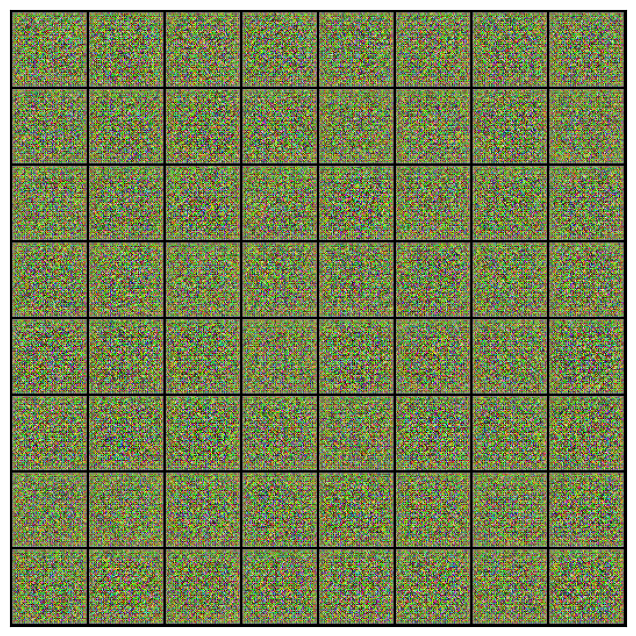

In [58]:
xb = torch.randn(batch_size, latent_size, 1, 1)  # random latent tensors. randn(tensor's shape)
print(xb.shape)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [59]:
generator = to_device(generator, device)

In [60]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_target)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [61]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [62]:
from torchvision.utils import save_image

In [63]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [65]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))